In [1]:
#
##
### LOAD DATA

import pandas as pd
import numpy as np

def _optimize_numeric_dtypes(df):
    import pandas as pd
    float_cols = df.select_dtypes("float").columns
    int_cols = df.select_dtypes("integer").columns
    df[float_cols] = df[float_cols].\
        apply(pd.to_numeric, downcast="float")
    df[int_cols] = df[int_cols].\
        apply(pd.to_numeric, downcast="integer")
    return df

data = _optimize_numeric_dtypes(
    pd.read_parquet("../data/customer_model/retailrocket/"))
data["target_cap"] = data["target_cap"].clip(-1000,10000)

#
##
### CONSTRUCT PROFIT TARGET
# NOTE: encapsulate this
config = {
    #"gamma":{"alpha":22.3, "beta":200},
    "gamma":{"alpha":20.5, "beta":116.167},
    "delta":500,
    "psi":{"alpha":9, "beta":1},
    "n_iter":1000,
    "seed":1}

gamma = config["gamma"]
delta = config["delta"]
psi = config["psi"]
n_iter = config["n_iter"]
seed = config["seed"] 

n_users = data.user_id.nunique()
sp = []
for i in range(n_iter):
    gamma_psi = pd.DataFrame.from_dict({
        "user_id":data.user_id.unique(),
        "gamma":np.random.beta(gamma["alpha"], gamma["beta"], size=n_users),
        "psi":np.random.beta(psi["alpha"], psi["beta"], size=n_users)})
    temp = data.merge(gamma_psi, on=["user_id"])
    temp["acp"] = (temp["target_event"]*temp["gamma"]*(temp["target_cap"]-delta)
        + (1-temp["target_event"])*(-temp["psi"]*delta))
    sp.append(temp.loc[:,["user_id", "week_step", "acp"]])
sp = pd.concat(sp)

In [2]:
out_cols = ["user_id", "row_id", "target_event",
    "target_revenue", "week_step", "target_cap",
    "cap", "cap_month_lag0", "cap_month_lag1",
    "cap_month_lag2", "cap_month_lag3", "cap_month_ma3"]

feat_cols = [c for c in data.columns if c not in set(out_cols)]


In [3]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

data = data.merge(sp.groupby(["user_id","week_step"], as_index=False).acp.mean(), on=["user_id","week_step"])
trf = data.week_step>2
tef = data.week_step==2

target_cols = ["target_event", "acp"]
X_train, y_train = data.loc[trf,feat_cols], data.loc[trf,target_cols]
X_test, y_test = data.loc[tef,feat_cols], data.loc[tef,target_cols]

# train split
#X_reg, X_clf, y_reg, y_clf = train_test_split(X_train, y_train, test_size=.8, stratify=y_train.loc[:,["target_event"]])

#clf = LGBMClassifier()
#clf.fit(X_clf, y_clf.loc[:,["target_event"]])
#X_reg["proba"] = clf.predict_proba(X_reg)[:,1]
#X_test["proba"] = clf.predict_proba(X_test)[:,1]

In [4]:
from sklearn.metrics import r2_score
from imblearn.pipeline import Pipeline
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import HistGradientBoostingRegressor

reg = HistGradientBoostingRegressor(loss="quantile",quantile=0.5)
reg = LGBMRegressor()
reg.fit(X_train, y_train.loc[:,["acp"]])
r2_score(y_test.loc[:,["acp"]], reg.predict(X_test))

0.46849853301491273

In [5]:
data.loc[:,["user_id","week_step","acp"]]

,user_id,week_step,acp
0,3926,0,-449.442359
1,8043,0,-447.088609
2,8731,0,-449.296341
3,9145,0,-450.556614
4,11248,0,-449.404823
...,...,...,...
3339,1352334,10,-448.226774
3340,1356496,10,-451.085552
3341,1365706,10,1419.222522
3342,1398811,10,198.553328


In [6]:
data.loc[data.user_id==566009,["user_id","week_step","acp"]].sort_values("week_step", ascending=False)

,user_id,week_step,acp
3242,566009,10,601.798121
3049,566009,9,-451.223492
2826,566009,8,471.759518
2583,566009,7,-451.223492
2312,566009,6,-451.223492
2010,566009,5,-451.223492
1683,566009,4,-451.223492
1336,566009,3,1419.995034
965,566009,2,1328.918737
576,566009,1,1248.293665


In [7]:
data.loc[data.user_id==566009,["user_id","week_step","acp"]].sort_values("week_step", ascending=False).acp.shift(1)

3242            NaN
3049     601.798121
2826    -451.223492
2583     471.759518
2312    -451.223492
2010    -451.223492
1683    -451.223492
1336    -451.223492
965     1419.995034
576     1328.918737
170     1248.293665
Name: acp, dtype: float64

In [8]:
shfty = 4
np.corrcoef(data.loc[:,["user_id","week_step","acp"]].sort_values("week_step", ascending=False).acp[shfty:],
    data.loc[:,["user_id","week_step","acp"]].sort_values("week_step", ascending=False).acp.shift(shfty)[shfty:])

array([[1.        , 0.02057505],
       [0.02057505, 1.        ]])

In [9]:
np.corrcoef(data.loc[:,["user_id","week_step","acp"]].sort_values("week_step", ascending=False).acp,
    data.loc[:,["user_id","week_step","acp"]].sort_values("week_step", ascending=False).groupby(["user_id","week_step"]).acp.shift(1).fillna(0))

/home/mf/github/churn-modeling/.env/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/mf/github/churn-modeling/.env/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


array([[ 1., nan],
       [nan, nan]])

In [10]:
sortd = data.loc[:,["user_id","week_step","acp", "target_event"]].sort_values("week_step", ascending=False)
np.corrcoef(
    sortd.loc[:,["acp"]].T,
    sortd.groupby(["user_id"], as_index=False).target_event.shift(1).fillna(0).T
)

array([[1.        , 0.56712684],
       [0.56712684, 1.        ]])

In [12]:
sortd["acp_lag1"] = sortd.groupby(["user_id"], as_index=False).acp.shift(1).fillna(0)
sortd["acp_lag2"] = sortd.groupby(["user_id"], as_index=False).acp.shift(2).fillna(0)
sortd["acp_lag3"] = sortd.groupby(["user_id"], as_index=False).acp.shift(3).fillna(0)
sortd["acp_lag4"] = sortd.groupby(["user_id"], as_index=False).acp.shift(4).fillna(0)

sortd["te_lag1"] = sortd.groupby(["user_id"], as_index=False).target_event.shift(1).fillna(0)
sortd["te_lag2"] = sortd.groupby(["user_id"], as_index=False).target_event.shift(2).fillna(0)
sortd["te_lag3"] = sortd.groupby(["user_id"], as_index=False).target_event.shift(3).fillna(0)
sortd["te_lag4"] = sortd.groupby(["user_id"], as_index=False).target_event.shift(4).fillna(0)

feat_cols = [c for c in sortd.columns if ("acp_" in c) or ("te_" in c)]
target_col = ["acp"]

train_filter = (sortd.week_step>1) & (sortd.week_step<11)
test_filter = sortd.week_step==1

X_train, y_train = sortd.loc[train_filter, feat_cols], sortd.loc[train_filter, target_col]
#X_train["proba"] = clf.predict_proba(X_train)[:,1]+np.random.random()
X_test, y_test = sortd.loc[test_filter, feat_cols], sortd.loc[test_filter, target_col]
#X_test["proba"] = clf.predict_proba(X_test)[:,1]#+np.random.random()/10

lr = LGBMRegressor(n_estimators=50)
lr.fit(X_train, y_train)

r2_score(y_test, lr.predict(X_test))

0.3598099569185369

<AxesSubplot:ylabel='Frequency'>

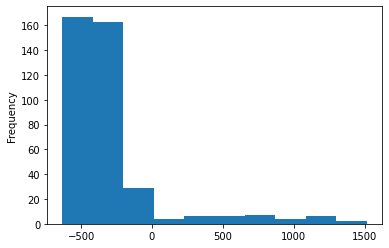

In [13]:
pd.Series(lr.predict(X_test)).plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

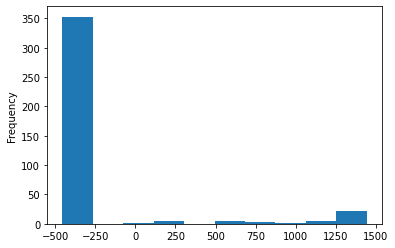

In [14]:
pd.Series(y_test.acp.values).plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

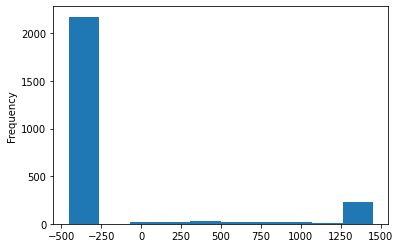

In [15]:
pd.Series(y_train.acp.values).plot(kind="hist")

In [19]:
data.loc[data.user_id==23076,:].sort_values("week_step", ascending=False).loc[:,["week_step","purchase_count_month_lag2","target_event"]]

,week_step,purchase_count_month_lag2,target_event
2480,7,0,0
2197,6,1,0
1890,5,1,0
1553,4,0,0
1194,3,0,0
817,2,0,1
423,1,0,1
10,0,0,1


In [20]:
np.corrcoef(data.purchase_count_month_lag0, data.target_event)

array([[ 1.       , -0.0055244],
       [-0.0055244,  1.       ]])

In [26]:
srtd = data.sort_values("week_step", ascending=False).copy()
srtd["target_lag"] = srtd.groupby("user_id").target_event.shift(1).fillna(0)

np.corrcoef(srtd.target_event, srtd.target_lag)

array([[1.        , 0.60056359],
       [0.60056359, 1.        ]])